# Import Libraries and Dataset

In [ ]:
# Import necessary libraries
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/B. Tech project/dataset_phishing.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Count the number of True and False labels in the 'status' column
true_false_counts = df['status'].value_counts()

# Display the count of Legitimate and phishing
print("\nCount of legitimate url in dataset:", true_false_counts['legitimate'])
print("Count of phishing url in dataset:", true_false_counts['phishing'])


Count of legitimate url in dataset: 5715
Count of phishing url in dataset: 5715


# Data Preprocessing

In [ ]:
# Step 3: Clean the data

features_to_drop = [
    'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks',
    'ratio_nullHyperlinks', 'nb_extCSS', 'ratio_intRedirection', 'ratio_extRedirection',
    'ratio_intErrors', 'ratio_extErrors', 'web_traffic', 'google_index', 'page_rank',
    'ratio_intMedia', 'ratio_extMedia'
]

# Drop the specified features
df = df.drop(columns=features_to_drop, errors='ignore')

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
url                           0
length_url                    0
length_hostname               0
ip                            0
nb_dots                       0
                             ..
whois_registered_domain       0
domain_registration_length    0
domain_age                    0
dns_record                    2
status                        0
Length: 74, dtype: int64


In [ ]:
# Display the rows with missing values
print("\nRows with missing values:")
print(df[df.isnull().any(axis=1)])

# Replace '?' and missing values with NaN
df.replace('?', np.nan, inplace=True)

# Convert to numeric and fill missing values with column mean
numeric_df = df.select_dtypes(include=np.number).copy()

# Use SimpleImputer to replace NaN values with column means
imputer = SimpleImputer(strategy='mean')
df[numeric_df.columns] = imputer.fit_transform(numeric_df)



Rows with missing values:
                                                     url  length_url  \
30                            http://www.enkiquotes.com/          26   
34     https://answers.yahoo.com/question/index?qid=2...          66   
37             http://yummy-cummy-in-my-tummy.tumblr.com          41   
75     https://documentos.sfo2.digitaloceanspaces.com...          57   
80     http://electricitypak.com/fakt/css/data/16/ind...          52   
82                    https://twitter.com/mimosagrillclt          34   
591    https://aquiferchidet.com/.jus/sbc/sbc/sbcglob...          56   
599                  https://www.madeleine-tarot.com/de/          35   
883    https://drive.google.com/file/d/1jIXB69T_Nw9tM...          70   
966                            http://www.bastelitis.de/          25   
984        https://paypal-support-help-inc.blogspot.com/          45   
1032            https://rekavloer.nl/wp-admin/user/chase          40   
1079                         http://n

In [ ]:
# Check for missing values
print("\nMissing values in the dataset after handling missing values :")
print(df.isnull().sum())


Missing values in the dataset after handling missing values :
url                           0
length_url                    0
length_hostname               0
ip                            0
nb_dots                       0
                             ..
whois_registered_domain       0
domain_registration_length    0
domain_age                    0
dns_record                    0
status                        0
Length: 74, dtype: int64


In [ ]:
# Display the rows with missing values
print("\nRows with missing values after handling missing values :")
print(df[df.isnull().any(axis=1)])


Rows with missing values after handling missing values :
Empty DataFrame
Columns: [url, length_url, length_hostname, ip, nb_dots, nb_hyphens, nb_at, nb_qm, nb_and, nb_or, nb_eq, nb_underscore, nb_tilde, nb_percent, nb_slash, nb_star, nb_colon, nb_comma, nb_semicolumn, nb_dollar, nb_space, nb_www, nb_com, nb_dslash, http_in_path, https_token, ratio_digits_url, ratio_digits_host, punycode, port, tld_in_path, tld_in_subdomain, abnormal_subdomain, nb_subdomains, prefix_suffix, random_domain, shortening_service, path_extension, nb_redirection, nb_external_redirection, length_words_raw, char_repeat, shortest_words_raw, shortest_word_host, shortest_word_path, longest_words_raw, longest_word_host, longest_word_path, avg_words_raw, avg_word_host, avg_word_path, phish_hints, domain_in_brand, brand_in_subdomain, brand_in_path, suspecious_tld, login_form, external_favicon, links_in_tags, submit_email, sfh, iframe, popup_window, safe_anchor, onmouseover, right_clic, empty_title, domain_in_title, d

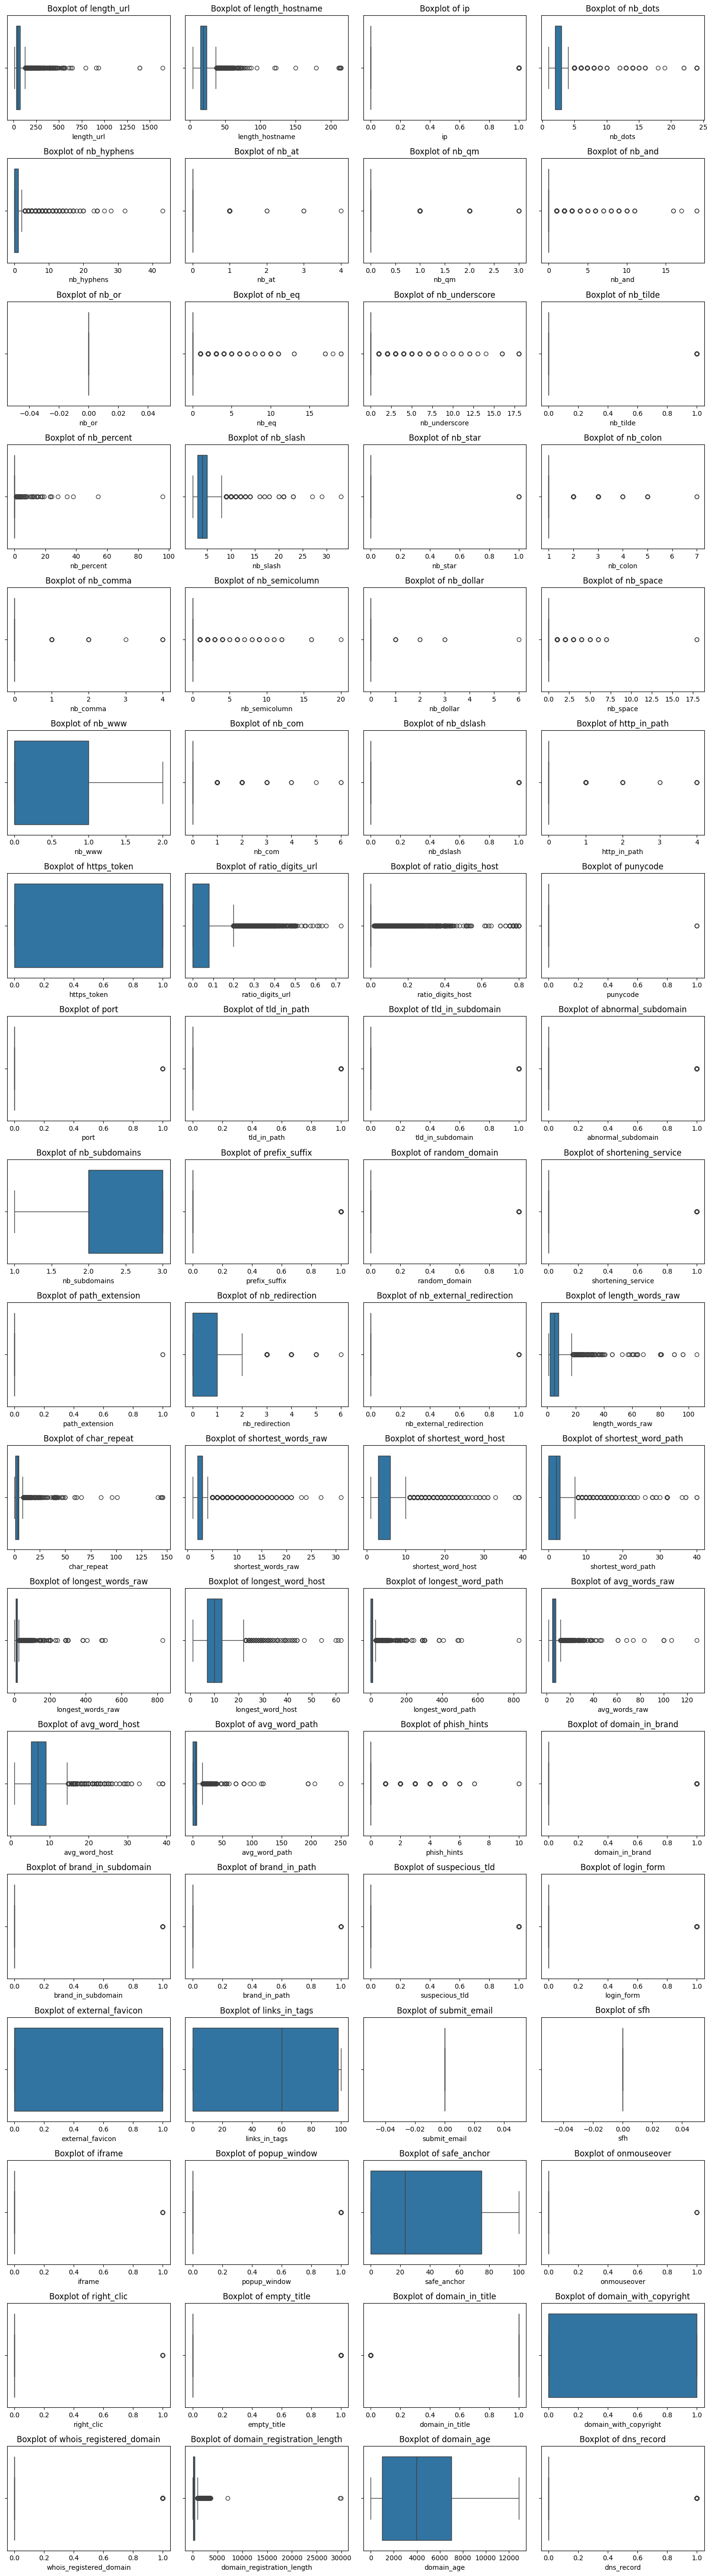

In [ ]:
num_cols = len(numeric_df.columns)
num_rows = int(np.ceil(num_cols / 4))  # Calculate rows for grid

plt.figure(figsize=(15, 3 * num_rows))

for i, column in enumerate(numeric_df.columns):
    plt.subplot(num_rows, 4, i + 1)  # Create subplot in grid
    sns.boxplot(x=numeric_df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [ ]:
#Handling The Outliers
def find_features_with_outliers(data, quantile_lower=0.10, quantile_upper=0.90, multiplier=2):
    features_with_outliers = []
    cnt = 0
    for column in data.columns:
        Q1 = data[column].quantile(quantile_lower)
        Q3 = data[column].quantile(quantile_upper)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        if any((data[column] < lower_bound) | (data[column] > upper_bound)):
            features_with_outliers.append(column)
            cnt += 1
    return features_with_outliers, cnt

def handle_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.10)
    Q3 = data[column].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    median_value = data[column].median()
    if data[column].dtype == np.int64:
        median_value = int(median_value)
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = median_value
    return data

# Step 1: Find and print count and features with outliers before handling
features_with_outliers, cnt = find_features_with_outliers(numeric_df)
print("Before Handling Outliers:")
print(f"Count of features with outliers: {cnt}")
print(f"Features with outliers: {features_with_outliers}")

# Step 2: Handle outliers
for column in features_with_outliers:
    numeric_df = handle_outliers_iqr(numeric_df, column)

# Step 3: Find and print count and features with outliers after handling
features_with_outliers, cnt = find_features_with_outliers(numeric_df)
print("\nAfter Handling Outliers:")
print(f"Count of features with outliers: {cnt}")
print(f"Features with outliers: {features_with_outliers}")

Before Handling Outliers:
Count of features with outliers: 54
Features with outliers: ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_com', 'nb_dslash', 'http_in_path', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'random_domain', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'login_form', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'whois_registered_domain', 'domain_registration_length', 'dns_record']

After Handling Outliers:
Count

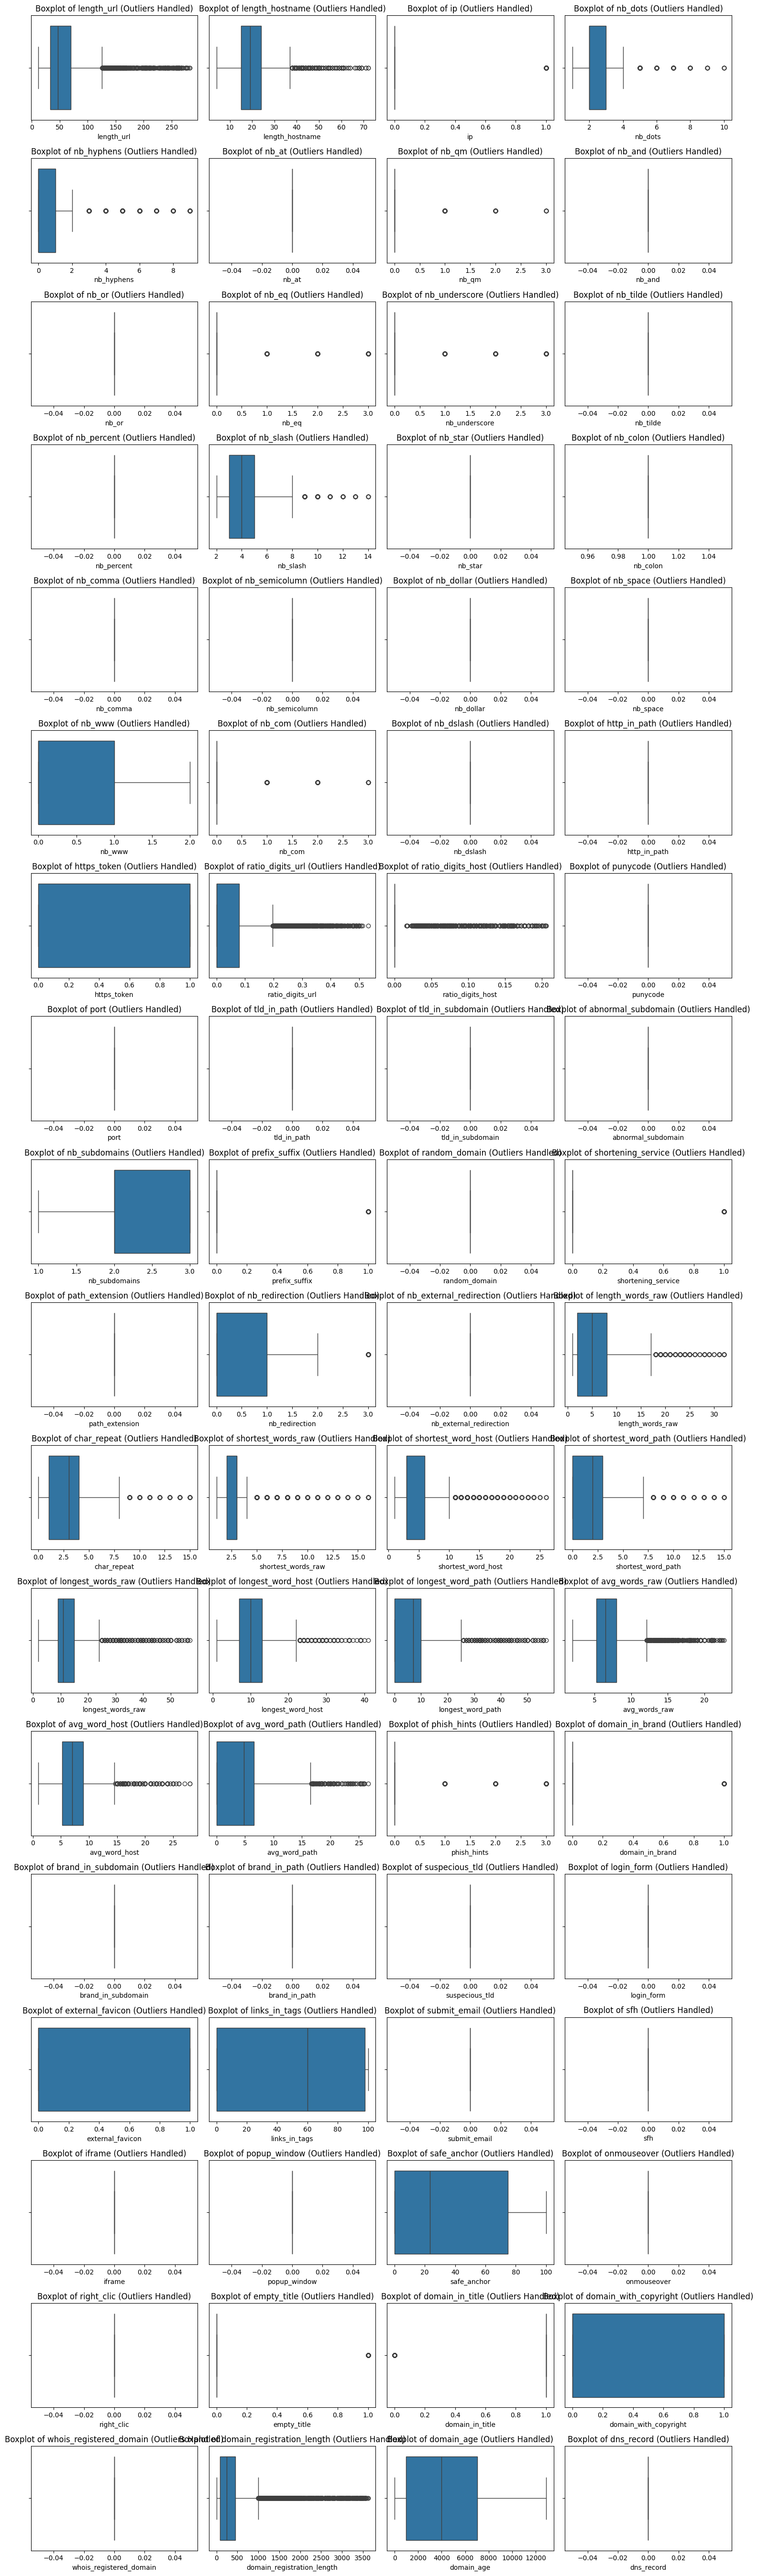

In [ ]:
#Boxplot after outlier Handling
plt.figure(figsize=(15, 3 * num_rows))

for i, column in enumerate(numeric_df.columns):
    plt.subplot(num_rows, 4, i + 1)
    sns.boxplot(x=numeric_df[column])
    plt.title(f'Boxplot of {column} (Outliers Handled)')

plt.tight_layout()
plt.show()

# PCA and Model Training

In [ ]:
# Step 1: Standardize the data before PCA
X = numeric_df
y = df['status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle NaNs if any
imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(X_scaled)

# Step 2: Apply PCA
pca = PCA()
pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

pca = PCA(n_components=num_components_95)
X_pca = pca.fit_transform(X_scaled)

# Display PCA results
print("Explained Variance Ratio per Component:")
print(pca.explained_variance_ratio_)
print(f"Number of components to retain 95% variance: {num_components_95}")

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=52)

# Step 5: Define models and hyperparameters
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    'SVM': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20]},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]},
    'Naive Bayes': {}
}

cv = StratifiedKFold(n_splits=10)
results = []
best_params = {}  # Dictionary to store best parameters for each model
best_accuracies = {}  # Dictionary to store best cross-validation accuracies for each model
best_test_accuracies = {}  # Dictionary to store test accuracies for each model
best_class_reports = {}  # Dictionary to store classification reports
best_conf_matrices = {}  # Dictionary to store confusion matrices

# Step 6: Perform grid search for each model
for model_name, model in models.items():
    print(f"\nPerforming GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params[model_name] = grid_search.best_params_
    best_accuracies[model_name] = grid_search.best_score_

    y_pred = grid_search.best_estimator_.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Store results for all parameter combinations
    for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        results.append({
            'Model': model_name,
            'Parameters': params,
            'Cross-Validation Accuracy': mean_score,
            'Test Accuracy': test_accuracy
        })

    # Store classification report and confusion matrix for the best model
    best_class_reports[model_name] = classification_report(y_test, y_pred)
    best_conf_matrices[model_name] = confusion_matrix(y_test, y_pred)
    best_test_accuracies[model_name] = test_accuracy  # Store test accuracy for later

# Step 7: Print results as a table
results_df = pd.DataFrame(results)

# Display the table first
print("\nDetailed Results Table:")
print(results_df)

# Save the results to a CSV file
results_df.to_csv("grid_search_results.csv", index=False)

# Step 8: Display best results for each model after the table
for model_name in models.keys():
    print(f"\nBest Parameters for {model_name}: {best_params[model_name]}")
    print(f"Cross-Validation Accuracy: {best_accuracies[model_name]:.4f}")
    print(f"Test Accuracy: {best_test_accuracies[model_name]:.4f}")  # Corrected this line
    print(f"Classification Report:\n{best_class_reports[model_name]}")
    print(f"Confusion Matrix:\n{best_conf_matrices[model_name]}")


Explained Variance Ratio per Component:
[0.17095012 0.09983001 0.06391171 0.05529913 0.05289903 0.04772581
 0.04311499 0.03592302 0.03513663 0.02832316 0.02703656 0.02599639
 0.0239471  0.02329513 0.02228585 0.02004064 0.01958599 0.01812222
 0.01802486 0.01721592 0.01630168 0.01538423 0.01499171 0.01427676
 0.0132132  0.0131256  0.00960257 0.00864532]
Number of components to retain 95% variance: 28

Performing GridSearchCV for KNN...

Performing GridSearchCV for SVM...

Performing GridSearchCV for Random Forest...

Performing GridSearchCV for Decision Tree...

Performing GridSearchCV for Naive Bayes...

Detailed Results Table:
            Model                                   Parameters  \
0             KNN     {'n_neighbors': 3, 'weights': 'uniform'}   
1             KNN    {'n_neighbors': 3, 'weights': 'distance'}   
2             KNN     {'n_neighbors': 5, 'weights': 'uniform'}   
3             KNN    {'n_neighbors': 5, 'weights': 'distance'}   
4             KNN     {'n_neighbors

# Model Evalution

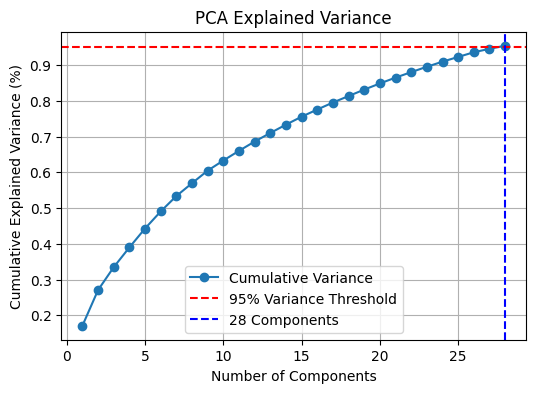

In [ ]:
#PCA Explained Varience Representation
# Fixed height for plots
fixed_height = 4

# Cumulative variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6, fixed_height))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.axhline(0.95, color='red', linestyle='--', label='95% Variance Threshold')
plt.axvline(num_components_95, color='blue', linestyle='--', label=f'{num_components_95} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

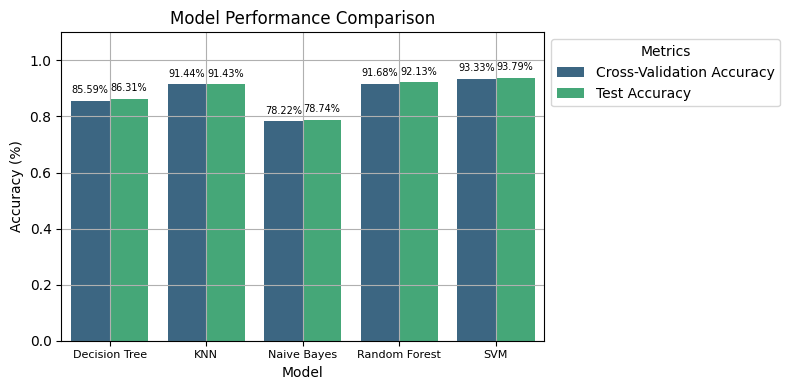

In [ ]:
fixed_height = 4
plt.figure(figsize=(8, fixed_height))
ax = sns.barplot(data=results_df_grouped.melt(id_vars='Model'), x='Model', y='value', hue='variable', palette='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.xticks(rotation=0)
plt.legend(title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))  # Outside the plot
plt.grid(True)

plt.ylim(0, 1.1)

# Add percentage labels above bars
for p in ax.patches:
    height = p.get_height()
    if height > 0.01:
        ax.text(p.get_x() + p.get_width() / 2., height + 0.02,
                f'{height:.2%}', ha="center", va='bottom', fontsize=7)

plt.tight_layout()
plt.show()


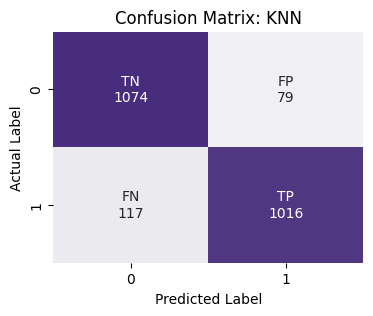

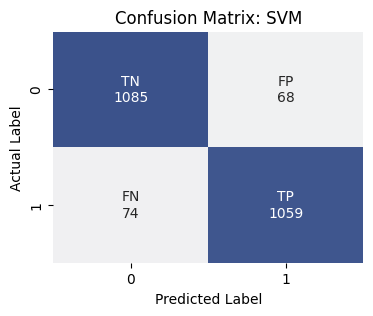

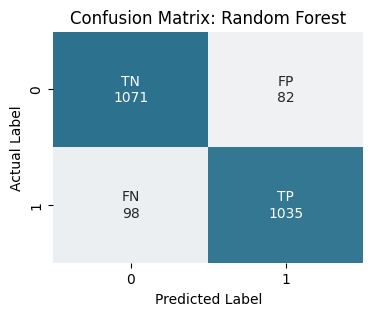

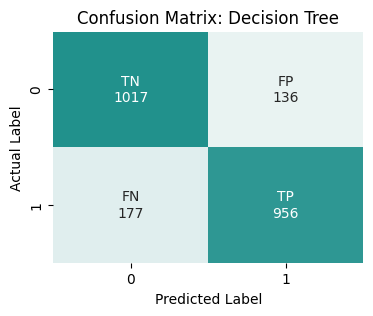

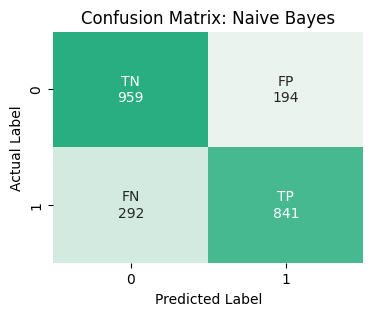

In [ ]:
base_palette = "viridis"
num_models = len(best_conf_matrices)

# Generate shades of the base palette
palette_shades = [sns.color_palette(base_palette, n_colors=num_models + 2)][0]

# Confusion matrix heatmaps with shades of the chosen palette and labels
for i, (model_name, conf_matrix) in enumerate(best_conf_matrices.items()):
    plt.figure(figsize=(fixed_height, fixed_height - 1))

    # Select the shade for this model's heatmap
    shade_index = i
    current_palette = [palette_shades[shade_index]]

    # Create labels with (TN, FP, FN, TP)
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0}".format(value) for value in conf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    # Create the heatmap with the chosen shade and labels
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap=sns.light_palette(current_palette[0], as_cmap=True), cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()
    print("\n")


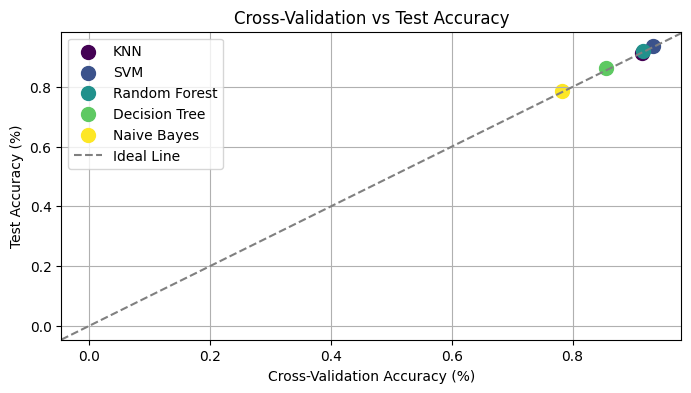

In [ ]:
# Cross-Validation vs Test Accuracy scatter plot
plt.figure(figsize=(8, fixed_height))
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(models)))

for i, model_name in enumerate(models.keys()):
    plt.scatter(best_accuracies[model_name], best_test_accuracies[model_name], label=model_name, s=100, color=colors[i])
plt.xlabel('Cross-Validation Accuracy (%)')
plt.ylabel('Test Accuracy (%)')
plt.title('Cross-Validation vs Test Accuracy')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='Ideal Line')
plt.legend()
plt.grid(True)
plt.show()

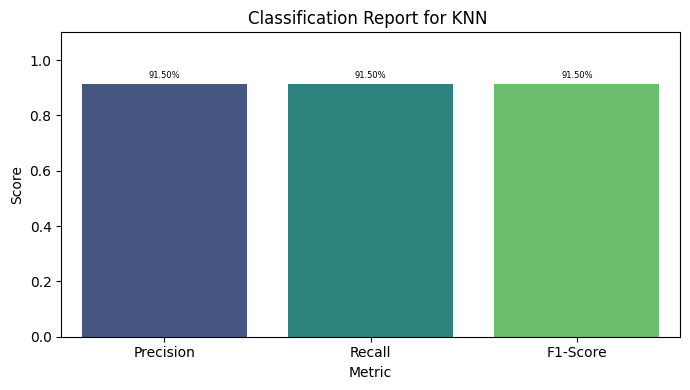

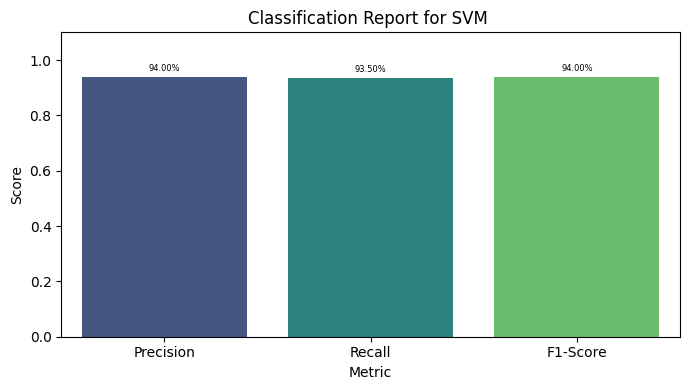

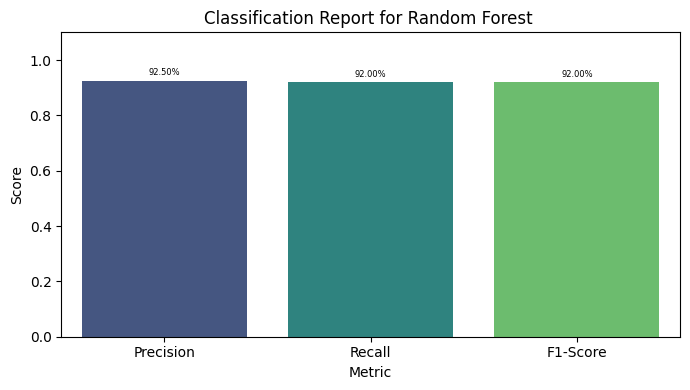

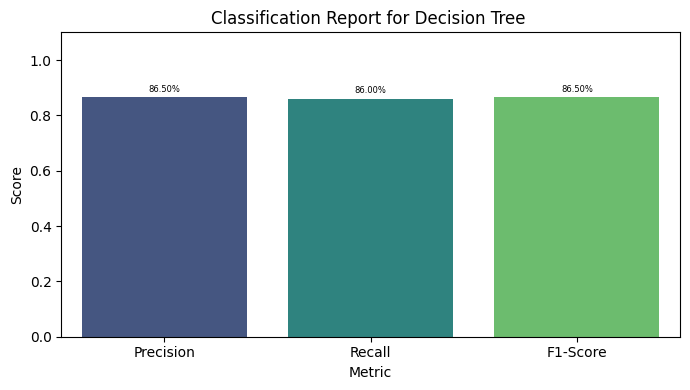

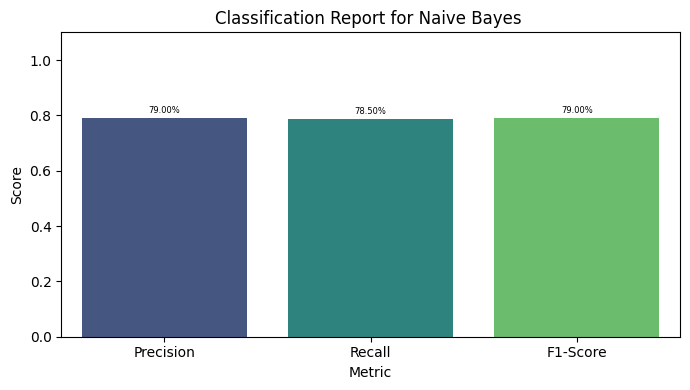

In [ ]:
for model_name, report in best_class_reports.items():
    # Extract data for the current model
    report_lines = report.split('\n')
    metrics = report_lines[2:-3]  # Extract relevant lines
    metrics = [line.strip().split() for line in metrics if line.strip()]

    table_data = []
    for metric in metrics:
        if len(metric) >= 4:
            metric[1] = float(metric[1])  # Precision
            metric[2] = float(metric[2])  # Recall
            metric[3] = float(metric[3])  # F1-Score
            table_data.append([model_name] + metric)

    # Create a DataFrame for the current model
    columns = ['Model', 'Label', 'Precision', 'Recall', 'F1-Score', 'Support']
    classification_df = pd.DataFrame(table_data, columns=columns)

    # Calculate average scores across labels
    average_scores = classification_df.groupby('Model')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

    # Melt the DataFrame to create a long-form structure
    average_scores_melted = pd.melt(average_scores, id_vars=['Model'],
                                       value_vars=['Precision', 'Recall', 'F1-Score'],
                                       var_name='Metric', value_name='Score')

    # Create the bar plot for the current model with updated Seaborn syntax
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(x='Metric', y='Score', hue='Metric', data=average_scores_melted,
                    palette='viridis', legend=False)
    plt.title(f"Classification Report for {model_name} ")
    plt.ylim(0, 1.1)
    plt.tight_layout()


    # Add percentage values on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.02,
                '{:.2%}'.format(height), ha="center", fontsize=6)

    plt.show()
    print("\n")

# Save trained model

In [ ]:
import pickle

# Step 1: Get the best estimators for each model using the already trained grid_search objects
best_estimators = {model_name: grid_search.best_estimator_ for model_name, grid_search in zip(models.keys(), [GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, n_jobs=-1, scoring='accuracy').fit(X_train, y_train) for model_name, model in models.items()])}

# Step 2: Create a dictionary to store the models, scaler, PCA, and accuracies
model_data = {
    'models': best_estimators,  # Best models for each algorithm
    'scaler': scaler,           # StandardScaler fitted on the data
    'pca': pca,                 # PCA fitted on the data
    'accuracies': best_test_accuracies  # Test accuracies for each model
}

# Step 3: Save the model data using pickle
filename = '/content/drive/My Drive/B. Tech project/combined_model2.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model_data, file)

print(f"Combined model saved to {filename}")


Combined model saved to /content/drive/My Drive/B. Tech project/combined_model2.pkl
